In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch-pretrained-bert pytorch-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 96.5 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
import pandas as pd
import io
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Responsible AI - Team #9 Folder/Data/(old) preprocessed_data.csv')
df.head()

,text,label
0,"This is so cool. It's like, 'would you want yo...",0
1,Thank you!! This would make my life a lot less...,0
2,This is such an urgent design problem; kudos t...,0
3,Is this something I'll be able to install on m...,0
4,haha you guys are a bunch of losers.,1


In [5]:
drop_percentage = 0.9976

category = 0
# Subset the DataFrame to include only rows with the specific category
category_df = df[df['label'] == category]

# Calculate the number of rows to drop based on the drop percentage
num_rows_to_drop = int(drop_percentage * len(category_df))

# Randomly sample rows to drop and store the remaining rows in a new DataFrame
remaining_rows = category_df.sample(n=len(category_df)-num_rows_to_drop, random_state=42)

# Subset the original DataFrame to exclude rows with the specific category and concatenate it with the remaining rows
df = pd.concat([df[df['label'] != category], remaining_rows])

In [6]:
drop_percentage = 0.972

category = 1
# Subset the DataFrame to include only rows with the specific category
category_df = df[df['label'] == category]

# Calculate the number of rows to drop based on the drop percentage
num_rows_to_drop = int(drop_percentage * len(category_df))

# Randomly sample rows to drop and store the remaining rows in a new DataFrame
remaining_rows = category_df.sample(n=len(category_df)-num_rows_to_drop, random_state=42)

# Subset the original DataFrame to exclude rows with the specific category and concatenate it with the remaining rows
df = pd.concat([df[df['label'] != category], remaining_rows])

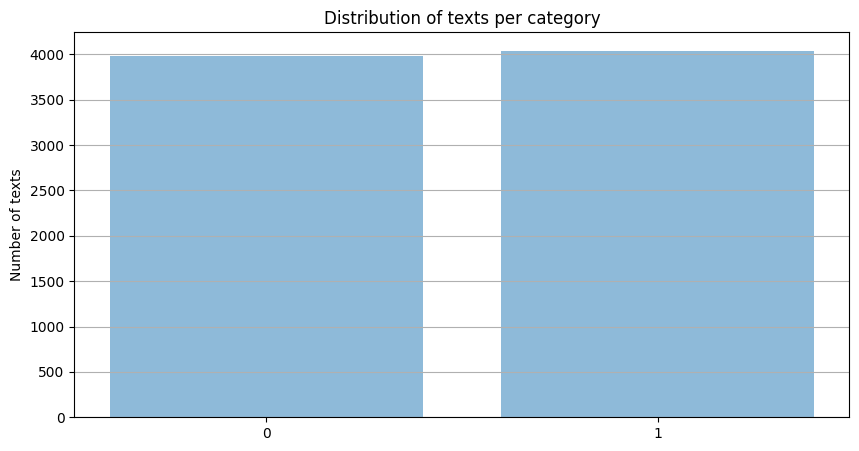

Counter({1: 4042, 0: 3986})


In [7]:
categories = df[['label']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [8]:
df.sample(10)

,text,label
746969,It's not a merger. It's the destruction of the...,0
1508715,Harry Truman was right... you can't get rich i...,1
359137,I agree - why buy a GM piece of junk corvette ...,1
1077130,"You sound real hard done by, buddy.",0
51397,ConMan Trump is a fast talking bullshit artist...,1
439068,"""A well designed carbon tax regime can be an e...",0
1084475,"Well somewhat, of the 216 million some are emp...",0
802399,It will reach 20 billion no doubt and there wi...,1
313714,When Barack Obama used the federal government ...,1
557094,What in God's name has Betsy DeVos accomplishe...,1


In [9]:
comments = df.text.values

comments = ["[CLS] " + comment + " [SEP]" for comment in comments]
labels = df.label.values

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(comment) for comment in comments]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 895084.05B/s]


Tokenize the first sentence:
['[CLS]', '.', 'the', 'next', 'time', 'you', 'buy', 'a', 'car', ',', 'all', 'things', 'being', 'equal', ',', 'do', 'yourself', ',', 'your', 'children', ',', 'your', 'community', 'and', 'your', 'country', 'a', 'positive', 'thing', 'and', 'consider', 'buying', 'a', 'model', 'from', 'one', 'of', 'the', 'companies', 'that', 'build', 'vehicles', 'in', 'your', 'country', '.', 'honda', ',', 'gm', ',', 'ford', ',', 'chrysler', ',', 'toyota', ',', 'all', 'build', 'cars', 'in', 'canada', ',', 'contributing', 'to', 'our', 'economy', 'and', 'keeping', 'large', 'amounts', 'of', 'canadian', 'wealth', ',', 'in', 'canada', 'when', 'someone', 'buys', 'a', 'bmw', ',', 'sub', '##aru', ',', 'hyundai', '/', 'kia', ',', 'mercedes', ',', 'volvo', ',', 'mazda', ',', 'nissan', ',', 'audi', '/', 'porsche', ',', 'v', '##w', ',', 'jaguar', ',', 'land', 'rover', ',', 'you', 'are', 'sending', 'most', 'of', 'the', 'purchase', 'price', 'of', 'the', 'vehicle', 'out', 'of', 'canada', ',', '

In [11]:
MAX_LEN = 128

In [12]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [13]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [14]:
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [15]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

In [16]:
train_inputs = torch.tensor(train_inputs).to('cuda')
validation_inputs = torch.tensor(validation_inputs).to('cuda')
train_labels = torch.tensor(train_labels).to('cuda')
validation_labels = torch.tensor(validation_labels).to('cuda')
train_masks = torch.tensor(train_masks).to('cuda')
validation_masks = torch.tensor(validation_masks).to('cuda')

In [17]:
batch_size = 64

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [18]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

100%|██████████| 407873900/407873900 [00:14<00:00, 27314267.23B/s]


In [19]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],'weight_decay_rate': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay_rate': 0.0}]

In [20]:
optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-5,warmup=.1)

In [21]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [22]:
t = [] 
train_loss_set = []
epochs = 10
device = 'cuda'
model.to(device)

for epoch in range(epochs):
  model.train()
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  for step, batch in enumerate(train_dataloader):
    b_input_ids, b_input_mask, b_labels = batch
    optimizer.zero_grad()
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    loss.backward()
    optimizer.step()
    
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  
  print("Epoch {}:".format(epoch+1))
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  for batch in validation_dataloader:
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

/usr/local/lib/python3.9/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Epoch 1:
Train loss: 0.46453053339392736
Validation Accuracy: 0.8389766483516484
Epoch 2:
Train loss: 0.2469966300161539
Validation Accuracy: 0.8678228021978023
Epoch 3:
Train loss: 0.12962267359932966
Validation Accuracy: 0.8507898351648352
Epoch 4:
Train loss: 0.0694085509862454
Validation Accuracy: 0.8492101648351649
Epoch 5:
Train loss: 0.036078275449211356
Validation Accuracy: 0.8548076923076924
Epoch 6:
Train loss: 0.020084693241324607
Validation Accuracy: 0.8570054945054946
Epoch 7:
Train loss: 0.013390800598864567
Validation Accuracy: 0.8410027472527472
Epoch 8:
Train loss: 0.012134758183790322
Validation Accuracy: 0.8558035714285714
Epoch 9:
Train loss: 0.009714531442057753
Validation Accuracy: 0.84739010989011
Epoch 10:
Train loss: 0.007123351025763915
Validation Accuracy: 0.851614010989011


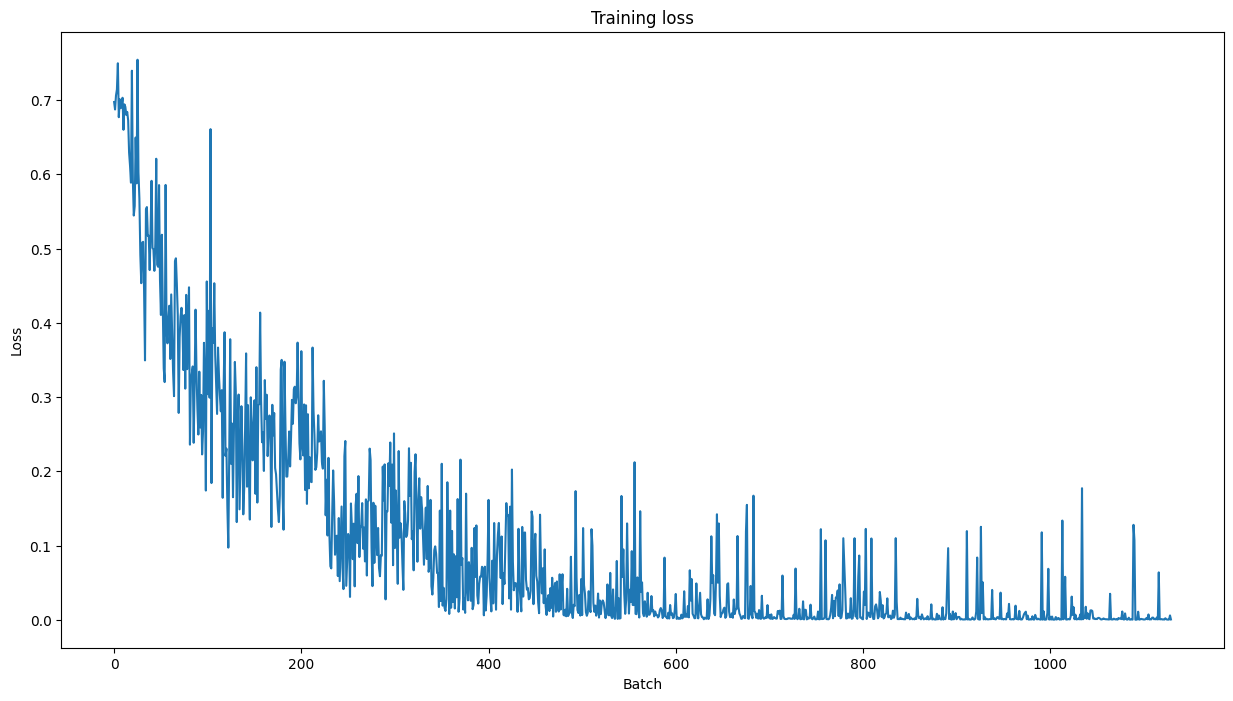

In [23]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [35]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Responsible AI - Team #9 Folder/model/BERT_pretrained.pth')

In [38]:
# Load Model
model2 = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2)
model2.load_state_dict(torch.load(f'/content/drive/MyDrive/Responsible AI - Team #9 Folder/model/BERT_pretrained.pth'))

In [45]:
# Saving the data on which the model was trained (complete dataset was not used)

import csv

data = list(zip(comments, labels))

# Save the data to a CSV file
output_file = 'output.csv'
with open(output_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Comments', 'Labels'])  # Write header row
    writer.writerows(data)